In [1]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping, ModelCheckpoint, global_step_from_engine
import monai
from monai.transforms import *
from monai.losses import *
from monai.utils import set_determinism
from monai.data import Dataset, PatchIterd, GridPatchDataset, CacheDataset, PersistentDataset, DataLoader
from monai.transforms import Resample
import sys
import psutil
from copy import deepcopy
device = f'cuda:0'

Load all the filenames

In [2]:
path_X = '/mnt/volume1/hecktor_2022/hecktor2022/imagesTr'
path_Y = '/mnt/volume1/hecktor_2022/hecktor2022/labelsTr'
files_Y = sorted(os.listdir(path_Y))

filenames = []
for file_Y in files_Y:
    file_CT = file_Y.split('.')[0]+'__CT.nii.gz'
    file_PT = file_Y.split('.')[0]+'__PT.nii.gz'
    file_GT = file_Y
    filenames.append({'CT':f'{path_X}/{file_CT}',
                      'PT':f'{path_X}/{file_PT}',
                      'GT':f'{path_Y}/{file_GT}'})

Make the dataset, and define the transformation pipeline. We will resize all images such that axial slices are 128x128, and adjust the CT and GT images using affine matrices to correspond to the PT image.

* Note that `ResampleToMatchd` assumes that `data` contains (for each `key` in `['CT', 'GT']` below) a `{key}_meta_dict`  dictionary that contains an `affine` field. That way, both the `CT` and the `GT` image can be resampled to the `PT` image in the `ResampleToMatchd` function in the `transform` below. This requires `image_only=False` when loading the data using `LoadImaged` so that the meta_dict information can be loaded as well.

* `bilinear` is used for CT (best interpolation) but `nearest` is used for the GT mask to ensure that the segmentation labels remain discrete

In [3]:
fn_keys = ['CT', 'PT', 'GT']
CT_min = -1025
CT_max = 1250

transform= Compose([LoadImaged(fn_keys, image_only=False),
                    ScaleIntensityRanged('CT', a_min=CT_min, a_max=CT_max, b_min=0, b_max=1, clip=True), #clip and scale CT
                    ScaleIntensityd('PT', minv=0, maxv=1), #scale PET
                    AddChanneld(fn_keys),
                    ResampleToMatchd(['CT', 'GT'], key_dst='PT', mode=['bilinear', 'nearest']), #resample CT and GT to match PET
                    Resized(fn_keys, (128,128,-1), mode=['area', 'area', 'nearest-exact']),
                    Transposed(fn_keys, (3,0,1,2)), #sup/inf axis comes first
                    ConcatItemsd(['CT', 'PT'], 'X', dim=1), #concatenate CT and PT into single model input
                    DeleteItemsd(['CT', 'PT']), #delete old items to free memory
                    CastToTyped('GT', dtype=torch.long),
                    ToDeviced(['X', 'GT'], device)
                          ])

This cache dataset stores all the data in memory, so the pipeline does not need to be executed each training iteration

In [4]:
ds = CacheDataset(data=filenames[:20], transform=transform)
test_ds = CacheDataset(data=filenames[20:30], transform=transform)

Loading dataset: 100%|███████████████████████████| 10/10 [00:31<00:00,  3.15s/it]


Based on the above, should take about 22 minutes to load full data into the cache (neglibible compared to training time). Lets see how much memory this takes up

In [5]:
print(f'RAM memory % used: {psutil.virtual_memory()[3]/1e9} GB')
print(f'RAM memory % used for total data: {psutil.virtual_memory()[3]/1e9 *len(filenames)/20} GB')

RAM memory % used: 3.862560768 GB
RAM memory % used for total data: 101.19877017600001 GB


For the total dataset, this is totally manageable by the RONIN computers we have (244GB is available with 4GPUs). Now lets make a dataloader:

In [6]:
dl = DataLoader(ds, batch_size=1, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

Define model

In [7]:
model = monai.networks.nets.UNet(spatial_dims=2, in_channels=6, out_channels=3,
                                 channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2)).to(device)

Train, looping over individual 2D slices:

In [8]:
n_epochs=100

Function that is called every train step:

In [9]:
def train_step(engine, batch):
    model.train()
    x_all, y_all = batch['X'][0], batch['GT'][0]
    total_loss = 0
    for i in range(1, x_all.shape[0]-1):
        x = torch.concat(list(x_all[i-1:i+2]))[None]
        y = y_all[i][None]
        _y = model(x)
        optimizer.zero_grad()
        loss = criterion(_y,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return loss.item()

Prepare a batch for validation, consisting of all the axial slices (3 PET, 3 CT) in the entire scan. The shape will be `[H,6,128,128]`. Then, during validation, metrics can be computed across entire images

In [10]:
def prepare_batch_fn(batch, device, non_blocking):
    X = batch['X'][0]
    X_processed = torch.zeros(X.shape[0], 6, X.shape[2], X.shape[3]).to(device) 
    for i in range(1, X.shape[0]-1):
        X_processed[i] = torch.concat(list(X[i-1:i+2]))[None]
    return X_processed[1:-1], batch['GT'][0][1:-1]

Optimizer and criteria used during model training:

In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = DiceCELoss(to_onehot_y=True, lambda_ce=100.,
                       ce_weight=torch.tensor([1.,100.,100.]).to(device))


metrics = {'Loss': Loss(criterion),
          'Dice': Loss(DiceLoss(to_onehot_y=True)),
          'CE': Loss(DiceCELoss(to_onehot_y=True, lambda_dice=0, ce_weight=torch.tensor([1.,100.,100.]).to(device)))}

Engine used for training (uses the `train_step` function above)

In [12]:
trainer = Engine(train_step)
evaluator = create_supervised_evaluator(model, metrics=metrics, device=device,
                                        prepare_batch = prepare_batch_fn,
                                        output_transform = lambda x, y, _y: (_y, y))

Save models during training

In [14]:
'''Early Stopping and saving best models only'''
def score_function(engine):
    return -engine.state.metrics['Dice']
handler = ModelCheckpoint(dirname = f'/mnt/volume1/hecktor_2022/results/models',
                           filename_prefix = 'best',
                           n_saved=2,
                           create_dir=True,
                           score_function = score_function,
                           global_step_transform = global_step_from_engine(trainer))
evaluator.add_event_handler(Events.COMPLETED, handler, {'mymodel': model})

Train

In [15]:
trn_losses = []
val_losses = {key: [] for key in metrics.keys()}

@trainer.on(Events.ITERATION_COMPLETED(every=1))
def log_training_loss(trainer, verbose=False):
    trn_losses.append(trainer.state.output)
    if verbose: print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.8f}", end='\r')
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(test_dl)
    computed_metrics = evaluator.state.metrics
    for key in metrics.keys():
        val_losses[key].append(computed_metrics[key])
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg loss: {computed_metrics['Loss']:.5f} \n")
    
trainer.run(dl, max_epochs=n_epochs)

Validation Results - Epoch: 1  Avg loss: 8.05865 

Validation Results - Epoch: 2  Avg loss: 8.97181 

Validation Results - Epoch: 3  Avg loss: 6.08153 

Validation Results - Epoch: 4  Avg loss: 3.59258 

Validation Results - Epoch: 5  Avg loss: 2.98621 

Validation Results - Epoch: 6  Avg loss: 3.30255 

Validation Results - Epoch: 7  Avg loss: 4.63248 

Validation Results - Epoch: 8  Avg loss: 4.19467 

Validation Results - Epoch: 9  Avg loss: 3.92899 

Validation Results - Epoch: 10  Avg loss: 3.29191 

Validation Results - Epoch: 11  Avg loss: 4.71478 

Validation Results - Epoch: 12  Avg loss: 6.79508 

Validation Results - Epoch: 13  Avg loss: 4.18540 

Validation Results - Epoch: 14  Avg loss: 3.76145 

Validation Results - Epoch: 15  Avg loss: 5.44194 

Validation Results - Epoch: 16  Avg loss: 4.23719 

Validation Results - Epoch: 17  Avg loss: 5.63686 

Validation Results - Epoch: 18  Avg loss: 6.09015 

Validation Results - Epoch: 19  Avg loss: 6.39116 

Validation Results - 

State:
	iteration: 2000
	epoch: 100
	epoch_length: 20
	max_epochs: 100
	output: 0.36190304160118103
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'monai.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

# Predictions

We use the `Invertd` to apply the inverse of all the invertible transforms applied to `GT` in the `transform` pipeline above

In [16]:
transform_inverse = Compose([Transposed('GTp', (1,0,2,3)), #first three transforms are to get argmax along 1st (channel in this case) axis
                             AsDiscreted('GTp', argmax=True),
                             Transposed('GTp', (1,0,2,3)),
                             Invertd(keys='GTp', transform=transform, orig_keys='GT', allow_missing_keys=True), #invert all spatial transforms on predicted GT
                             SqueezeDimd('GTp', dim=0),
                            ])

Predict a sample data point

In [17]:
def model_prediction(model, X, model_type='2D'):
    if model_type=='2.5D':
        y_new = torch.zeros((X.shape[0], 3, X.shape[2], X.shape[3]))
        for i in range(1, X.shape[0]-1):
            y_new[i] = model(torch.concat(list(X[i-1:i+2]))[None])
        return y_new

In [18]:
data = transform(filenames[4])
data['GTp'] = model_prediction(model, data['X'], model_type='2.5D')
_y = transform_inverse(data)['GTp']
raw = LoadImaged(fn_keys)(filenames[4])
y, CT, GT = raw['GT'], raw['CT'], raw['PT']

And plot in the CT image space (this is how our submission need to be given):

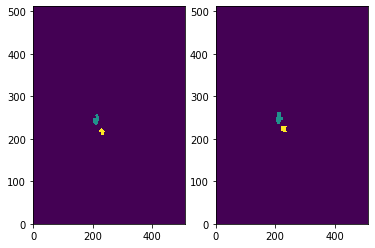

In [19]:
plt.subplots(1,2)
plt.subplot(121)
plt.pcolormesh(y[:,:,153].cpu())
plt.subplot(122)
plt.pcolormesh(_y[:,:,153].cpu())

Alternatively, can plot in the PET image space:

In [508]:
s = 4
slc = 53

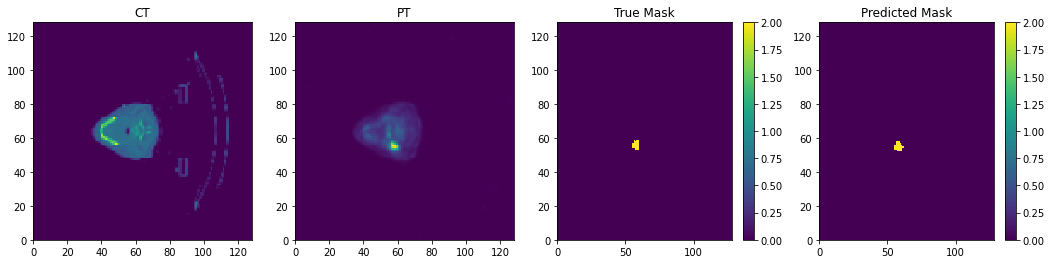

In [509]:
plt.subplots(1,4,figsize=(18,4))
plt.subplot(141)
plt.title('CT')
plt.pcolormesh(data['X'][slc][0].cpu())
plt.subplot(142)
plt.title('PT')
plt.pcolormesh(data['X'][slc][1].cpu())
plt.subplot(143)
plt.title('True Mask')
plt.pcolormesh(data['GT'][slc][0].cpu())
plt.colorbar()
plt.subplot(144)
plt.title('Predicted Mask')
plt.pcolormesh(torch.argmax(data['GTp'], axis=1)[slc].cpu())
plt.colorbar()

# Extra

In [171]:
CT = ds[4]['X'][:,0].cpu()
PT = ds[4]['X'][:,1].cpu()
GT = ds[4]['GT'][:,0].cpu()

In [172]:
np.unique(GT)

array([0, 1, 2])

In [173]:
np.unique(np.where(GT)[0])

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

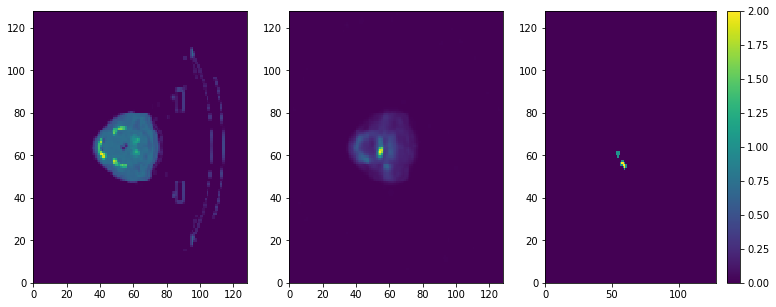

In [180]:
plt.subplots(1,3,figsize=(13,5))
plt.subplot(131)
plt.pcolormesh(CT[56])
plt.subplot(132)
plt.pcolormesh(PT[56])
plt.subplot(133)
plt.pcolormesh(GT[56])
plt.colorbar()

# Alternative to the Above Using SITK

In [ ]:
import SimpleITK as sitk

In [ ]:
ctimg = sitk.ReadImage(filenames[2]['CT'], imageIO="NiftiImageIO")
ptimg = sitk.ReadImage(filenames[2]['PT'], imageIO="NiftiImageIO") 
gtimg = sitk.ReadImage(filenames[2]['GT'], imageIO="NiftiImageIO") 

In [ ]:
resampled_ctimg = sitk.Resample(ctimg, ptimg, interpolator=sitk.sitkLinear, defaultPixelValue=-1024)
resampled_gtimg = sitk.Resample(gtimg, ptimg, interpolator=sitk.sitkNearestNeighbor, defaultPixelValue=0)

In [ ]:
resampled_ctimg

In [16]:
im = sitk.GetArrayFromImage(resampled_ctimg)

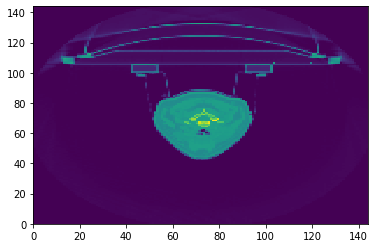

In [20]:
plt.pcolormesh(im[50])